# 15 Transfer Learning

In [15]:
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time 
import os 
import copy 

In [16]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [17]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]), 
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
}

In [18]:
data_dir = 'data/hymenoptera_data'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in sets}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True) for x in sets}
dataset_sizes = {x: len(image_datasets[x]) for x in sets}
class_names = image_datasets['train'].classes 
class_names

['ants', 'bees']

In [19]:
def train_model(model, criteria, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {'train': {'acc': [], 'loss': []}, 'val': {'acc': [], 'loss': []}}
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch:2d}/{num_epochs-1}')
        print('-' * 10)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else: 
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criteria(outputs, labels)
                    
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
                        
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc 
                best_model_wts = copy.deepcopy(model.state_dict())
                
            history[phase]['acc'].append(epoch_acc)
            history[phase]['loss'].append(epoch_loss)
                
        print()
        
    time_elapsed = time.time() - since 
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}m')
    print(f'Best val Acc: {best_acc:.4f}')
    
    model.load_state_dict(best_model_wts)
    return model, history
                    

In [20]:
model = models.resnet18(pretrained=True)
# for param in model.parameters():
#     param.requires_grad = False
num_feat = model.fc.in_features
model.fc = nn.Linear(num_feat, 2)

/Users/manuelmartinezflores/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/manuelmartinezflores/opt/anaconda3/envs/pytorch/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [21]:
criteria = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [22]:
model, history = train_model(model, criteria, optimizer, step_lr_scheduler, num_epochs=15)

Epoch  0/14
----------
train Loss: 0.6530 Acc: 0.6189
val Loss: 0.4554 Acc: 0.8497

Epoch  1/14
----------
train Loss: 0.5079 Acc: 0.7705
val Loss: 0.3343 Acc: 0.8824

Epoch  2/14
----------
train Loss: 0.5011 Acc: 0.7623
val Loss: 0.2940 Acc: 0.9216

Epoch  3/14
----------
train Loss: 0.4155 Acc: 0.8197
val Loss: 0.3179 Acc: 0.8693

Epoch  4/14
----------
train Loss: 0.3796 Acc: 0.8443
val Loss: 0.2329 Acc: 0.9281

Epoch  5/14
----------
train Loss: 0.4121 Acc: 0.8033
val Loss: 0.2363 Acc: 0.9216

Epoch  6/14
----------
train Loss: 0.3538 Acc: 0.8566
val Loss: 0.2015 Acc: 0.9281

Epoch  7/14
----------
train Loss: 0.4122 Acc: 0.7828
val Loss: 0.2098 Acc: 0.9346

Epoch  8/14
----------
train Loss: 0.4228 Acc: 0.7910
val Loss: 0.2004 Acc: 0.9281

Epoch  9/14
----------
train Loss: 0.4226 Acc: 0.7951
val Loss: 0.1987 Acc: 0.9412

Epoch 10/14
----------
train Loss: 0.3622 Acc: 0.8525
val Loss: 0.2074 Acc: 0.9281

Epoch 11/14
----------
train Loss: 0.3697 Acc: 0.8566
val Loss: 0.2119 Acc: 

In [44]:
import seaborn as sns
plt.rcParams["figure.figsize"] = (10,20)

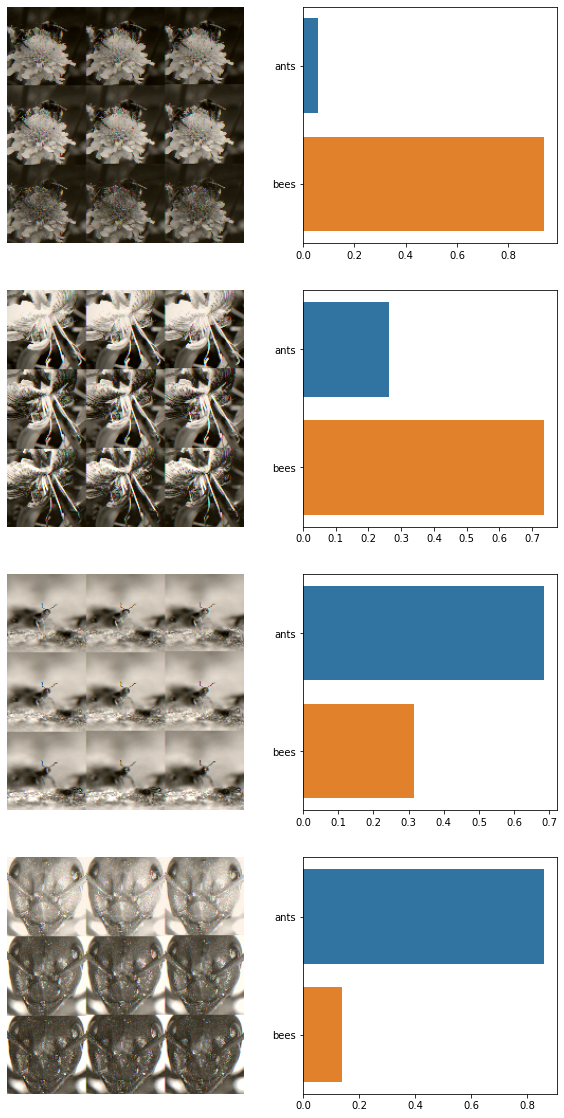

In [48]:
with torch.no_grad():
    images, labels = iter(dataloaders['val']).next()
    preds = nn.functional.softmax(model(images), 1)
    for k in range(1, 5):
        plt.subplot(4, 2, 2 * k - 1)
        plt.axis('off')
        plt.imshow(np.clip(images[k-1].view(224, 224, 3) * std + mean, 0, 1))
        plt.subplot(4, 2, 2 * k)
        sns.barplot(x = preds[k-1].numpy(), y = ['ants', 'bees'])
    plt.show()